# Energy Management in Buildings: Learning behavioral models from data [6h]
### author: stephane.ploix@grenoble-inp.fr

- __Student name(s)__:

- __Teaching program followed__: 

**Your answers to questions in assignment files, must be returned by one week after the latest session.**

__Prerequisites:__ Basic knowledge about modeling physical systems, plus basic skills of the Python language.

__Advice:__ Each question has a unique number so that you can use any kind of document to put your answers, providing the question numbers are mentioned. Don't wait for the end to test your way of collecting results. You can work directly in the notebook but be careful not to loose your responses (copy and export them regularly).

The lecture is designed as a tutorial to follow with an estimation of the needed time to solve each problem. It is composed of Jupyter notebooks, named notebookx_XXX.ipynb and example python files, located at the root folder. The core well-documented Python code is located in the _buildingenergy_ folder, but it's for curious people (it's not needed for solving the problems of the notebooks). Data like weather files (extension '.json'), thermal and physical properties (file named propertiesDB.xlsx) are located in the _data_ folder. When a file is generated, it will be located in the _result_ folder like physical parameters for simplified models (extension '.p'). All these folders can be reset thanks to the _"setup.ini" configuration file__

Regarding your working environment, it is recommended to:
- Install the latest available version of Python (3.9 minimum but preferably 3.11) activating the checkbox "Install in the path of your operating system", either directly from the [Python distribution site](https://www.python.org/downloads/), or by using [Anaconda](https://www.anaconda.com/products/distribution), that embeds Python together with additional useful scientific librairies.
- Load and install the latest version of (Visual Studio code)[https://code.visualstudio.com] for your operating system and load from the VS studio extensions: Python from Microsoft and Jupyter from Microsoft.
- Go to the [git site of the building energy project](https://gricad-gitlab.univ-grenoble-alpes.fr/ploixs/buildingenergy) and download it as a zip file. Unzip and open with Visual Studio code. If the Internet connection is not tool slow, you can access a [MyMinder](https://bit.ly/3QbtIPK) site, where the code can be remote remotely.
- In the terminal of Visual Studio code, you can installed the modules dependencies using ```python3.X -m pip install -r requirements.txt```where x stands for the number of the Python version selected in Visual Studio code.
- Open the working folder with the unzipped files and double-click on the notebook you want. 
- Execute each cell following the proposed order.
  
_______________________________________________

# 1. Introduction

We have developped models based on our knowledge but we notice that the resulting models are far from recorded measurements.

During this session, we are going to:

1) fit different kinds of linear regressions from the family of the auto-regressive models with external inputs (ARX). They belong to the so-called black box models. A nonlinear extension is known as artificial neural network (ANN). They are knowledge blind models but they are easy to tune because there are linear wrt the parameters. 
2) adjust the parameters of the knowledge model we have developped. For this purpose, we are going to use an greedy optimisation algorithm (a variant of the tabu search), to find better parameter values, i.e. parameter values that lead to simulated office temperature and CO2 concentration that better match the measurements. 
3) compare the fitted knowledge model to input-output regressive models

We are going to use a dataset covering October 12nd to November 29th, 2015 for learning models, all the recorded data for validation. Because we are handling real measurement data for a long period, gaps and failures occurred:

![Status of sensors](img/errors.png)

We are going to adjust the model parameters to better simulate the office temperature and its CO2 concentration during the whole period. It's named cross validation and it's usefull to detect over-fitting issues (i.e. modeling the random noise). It appears when the model is so precise (because of numerous parameters) that it's also explaining the random noise, which is distributed differently over another period. We use to call training or learning period the one use to adjust the parameters, and prediction or validation period the one that is used to detect over-fitting issues.

# Designing and calibrating linear regressive models [3h]

## 1. Introduction [15min]

In this part, we are going to use regressive models, namely ARX (Auto-Regressive with eXternal inputs) models. They are based on a very general structure given below and because of their structure, it’s very easy to minimize the difference between the measured data and the estimated ones. It is widely used in many different sectors because it does not require a deep knowledge of the system to be modelled. It's also called black-box model or observation models. We are going to compare the results to the knowledge model calibrated in the previous part.
An ARX model is a Multi-Inputs Mono-Output model (MISO), its means that we need to design 1 model for Office temperature and another one for CO2 concentration.
The main issue with these models is to design their structure:
- selecting the right input variables ($u_j$) and the time horizon they should cover (from $delay$ to $m_j$)
- selecting the right outputs with their delayed values ($y$) and the required number of past values (from $y_{k-1}$ to $y_{k-n}$).
- specifying whether there is an offset value or not.

An ARX model with an output $y$ ($y$ means measured value and $\hat y$ the related simulated value) and the following inputs $u_1,\dots, u_{\pi}$ can be written:
$$
    \hat{y}_{k} = -\alpha_1 \hat{y}_{k-1}-\dots-\alpha_n \hat{y}_{k-n}\dots\\
    \dots + \beta_{1,0} u_{1,k-delay}+\dots+\beta_{1,m_1-delay} u_{1,k-m_1}\\
    \dots \\
     + \beta_{\pi,0} u_{\pi,k-delay}+\dots+\beta_{\pi,m_1-delay} u_{\pi,k-m_\pi}\\
     + \text{offset}
$$
where:
- $n$ is the maximum output delay
- $delay$ is the minimum input delay common to all inputs (it's modeling a time delay in the response)
- $m_j$ are the maximum input delay for each input
- $\pi$ is the number of inputs

All these sizing parameters specify the complexity of the interpolating polynom and once they have been specify, a root mean square minimisation leads to the optimal parameters: like before the model has to be as precise as possible i.e. minimizing the error between the simulated output and the measured one. Like before, there is a trade-off between accuracy (involving higher complexity) and over-fitting issues (involving lower complexity).

In order to know whether the ARX model complexity should be increased or decrease, different indictors are frequently used:
- the value of a parameter $\alpha_i$ or $\beta_{j,\iota}$: if the value is closed to 0 and it's impact on output is little, it suggests that it can be neglected. If the parameter is with a maximum delay, the corresponding maximum output or input delay can be reduced by one.
- the zeros-poles compensation: with a transfer function perspective, the ARX model can represented as a sum of transfer functions with the same denominator containing $alpha_i$ parameters and a numerator corresonding to each input containing $\beta_{j,\iota}$ parameters. If there are zeros-poles compensation for each input, it suggests that simplifications are possible: the output maximum delay and the input maximum delays can be reduced by the same quantity. 
- the auto-correlation of the output error: if the output error (difference between ARX simulated output and the measurement) was a white noise it would have a maximum value at 0 and then the higher the delay is, the lower the correlation coefficient. If a peak appears, let's say at $p$, it suggests to check whether the maximum output coefficient should greater or equal to $p$.
- the cross-correlations between the output error and each input: with an similar reasoning than before, it suggests to check whether the maximum input delay is greater or equal to the peak delay $p$.
- the prediction error, related to another time period than the one used for fitting the ARX model, that should be similar to the output error obtained with the training dataset to detect over-fitting issues.

The method is then simple. For each output variable,
- define the input variables that may affect the simulated output
- start a simple structure i.e. with little maximum delays
- modify the sizing parameters to increase the model complexity
- check the resulting output error: does the improvement significant?
- analyse the previous indicators and determine whether complexity is enough or whether it should be increased.

## 2. Design of relevant ARX models [1h30]

For each output (office temperature and CO2 concentration), modify the sizing parameters until you reach a good precision/complexity compromize. To make it easy, the results are saved in markdown file *results.md* in a *linreg* folder that you should open with Visual Studio Code (with Markdown All In One extension for instance), Pycharm...

- According to the experience you got till now, determine the minimum and maximum possible order for the H358 office model.

__your result 2.1>__

- Determine 2 ARX models, a lightwise one and a more complex and precise one for representing the indoor office air temperature, using the previously mentionned indicators. You can modified the input and output names but also shape the stucture of the ARX model.

__your result 2.2>__

- Plot the akaike graph (see related slides) and determine the best compromize that limits the over-fitting.

__your result 2.3>__

from __future__ import annotations
import buildingenergy.linreg
import sites.data_h358
import sites.model_h358
import buildingenergy.data

training_data_provider: buildingenergy.data.DataProvider = sites.data_h358.make_h358_data_provider('12/10/2015', ending_stringdate = '31/12/2015')

validation_data_provider: buildingenergy.data.DataProvider = sites.data_h358.make_h358_data_provider()

######## tuning parameter zone #######
offset: bool = True
minimum_input_delay: int = 0
input_names: tuple[str] = ('weather_temperature', 'window_opening', 'door_opening', 'Tcorridor', 'total_electric_power', 'Psun_window', 'dT_heat', 'occupancy')
inputs_maximum_delays = 4 # (2, 0, 0, 0, 2, 1, 1)  # int: same delay for all inputs, or tuple[int], with specific delay for each input
output_name: str = 'Toffice_reference'
ouput_maximum_delay = 4
######################################

print(training_data_provider)

buildingenergy.linreg.arx_estimation(output_name, input_names, training_data_provider, validation_data_provider, offset=offset, minimum_input_delay=minimum_input_delay, inputs_maximum_delays=inputs_maximum_delays, ouput_maximum_delay=ouput_maximum_delay)
validation_data_provider.plot()


- What can we say about the relative importance of the corridor temperature? Is it predictible? What about the other variables?

__your result 2.4>__

- Propose a solution to avoid the 18h forcasting for day-anticipating energy management

__your result 2.5>__

- In the same way, propose an ARX model to estimate the CO2 concentration. What about the realism of the results?

__your result 2.6>__

In [3]:
from __future__ import annotations
import buildingenergy.linreg
import sites.data_h358
import sites.model_h358
import buildingenergy.data

training_data_provider: buildingenergy.data.DataProvider = sites.data_h358.make_h358_data_provider('12/10/2015', ending_stringdate = '31/12/2015')

validation_data_provider: buildingenergy.data.DataProvider = sites.data_h358.make_h358_data_provider()


######## tuning parameter zone #######
offset: bool = True
minimum_input_delay: int = 0
input_names: tuple[str] = ('window_opening', 'door_opening', 'occupancy', 'detected_motions')
inputs_maximum_delays = 4 # (2, 0, 0, 0, 2, 1, 1)  # int: same delay for each input of tuple[int], specific delay for each input
output_name: str = 'office_CO2_concentration'
ouput_maximum_delay = 4
######################################

print(training_data_provider)

buildingenergy.linreg.arx_estimation(output_name, input_names, training_data_provider, validation_data_provider, offset=offset, minimum_input_delay=minimum_input_delay, inputs_maximum_delays=inputs_maximum_delays, ouput_maximum_delay=ouput_maximum_delay)
validation_data_provider.plot()


variables read from file measurement file:
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, zetaW7, zetaW9, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, humidity, Tyanis, occupancy, detected_motions, illuminance_old, illuminance_new, dT_heat, power_heater, heating_level, total_electric_power, actual_occupation, acoustic_pressure_dB, 
Variable zetaW7 has been removed
Variable zetaW9 has been removed
Variable humidity has been removed
Variable Tyanis has been removed
Variable occupancy has been removed
Variable power_heater has been removed
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, detected_moti

NameError: name 'exit' is not defined

## 3. Sliding window for permanently adjusting parameters [45min]

In order to improve the quality of the estimation, we are going to use a sliding (rather jumping) window for estimating outputs. The generated log file is still named *results.md* in the *sliding* folder. 
- Reuse the previously determined ARX parameters, observe the results and compare. The sliding estimator is jumping by one slice (typically lasting 24 hours) each estimation step. It will consider data over a time period named memory.
  
  __your result 3.1>__

variables read from file measurement file:
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, zetaW7, zetaW9, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, humidity, Tyanis, occupancy, detected_motions, illuminance_old, illuminance_new, dT_heat, power_heater, heating_level, total_electric_power, actual_occupation, acoustic_pressure_dB, 
Variable zetaW7 has been removed
Variable zetaW9 has been removed
Variable humidity has been removed
Variable Tyanis has been removed
Variable occupancy has been removed
Variable power_heater has been removed
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, detected_moti

SelectMultiple(description='Select variable to plot', options=('Toffice_wall', 'Tcorridor', 'Theater', 'Toffic…

Button(description='Plot', style=ButtonStyle())

Output()

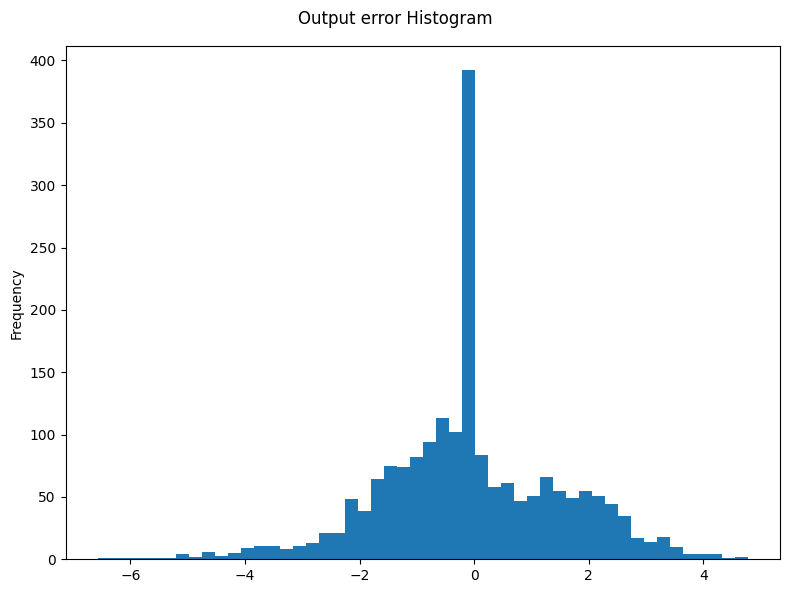

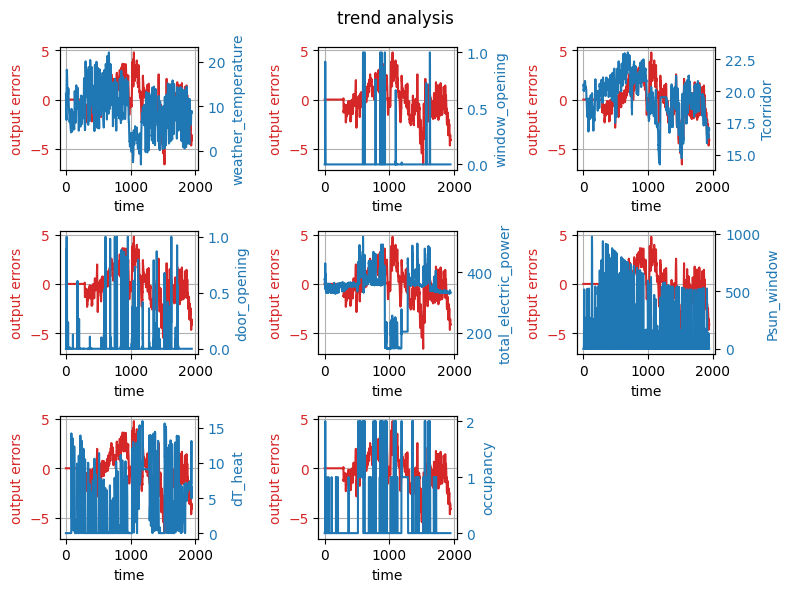

In [ ]:
from __future__ import annotations
import buildingenergy.linreg
import sites.data_h358
import sites.model_h358
import buildingenergy.data

training_data_provider: buildingenergy.data.DataProvider = sites.data_h358.make_h358_data_provider('12/10/2015', ending_stringdate = '31/12/2015')


######## tuning parameter zone #######
offset: bool = True
minimum_input_delay: int = 18
input_names: tuple[str] = ('weather_temperature', 'window_opening', 'Tcorridor', 'door_opening', 'total_electric_power', 'Psun_window', 'dT_heat', 'occupancy')
inputs_maximum_delays: tuple[int] = 24  # (2, 0, 0, 0, 2, 1, 1)
output_name: str = 'Toffice_reference'
ouput_maximum_delay: int = 24
######################################

buildingenergy.linreg.sliding_arx_estimation(output_name,input_names, training_data_provider, offset=offset, minimum_input_delay=minimum_input_delay, inputs_maximum_delays=inputs_maximum_delays, ouput_maximum_delay=ouput_maximum_delay, slice_size = 24, minimum_slices = 12, slice_memory = 24 * 7)

training_data_provider.plot()

- Same for CO2

__your result 3.2>__

variables read from file measurement file:
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, zetaW7, zetaW9, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, humidity, Tyanis, occupancy, detected_motions, illuminance_old, illuminance_new, dT_heat, power_heater, heating_level, total_electric_power, actual_occupation, acoustic_pressure_dB, 
Variable zetaW7 has been removed
Variable zetaW9 has been removed
Variable humidity has been removed
Variable Tyanis has been removed
Variable occupancy has been removed
Variable power_heater has been removed
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, detected_moti

SelectMultiple(description='Select variable to plot', options=('Toffice_wall', 'Tcorridor', 'Theater', 'Toffic…

Button(description='Plot', style=ButtonStyle())

Output()

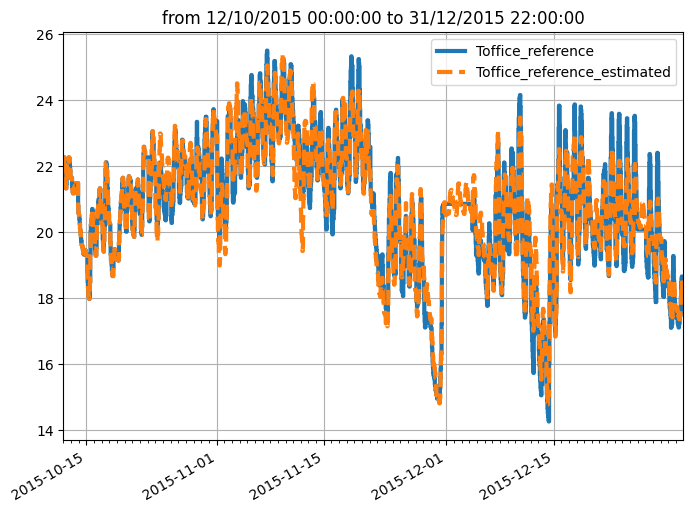

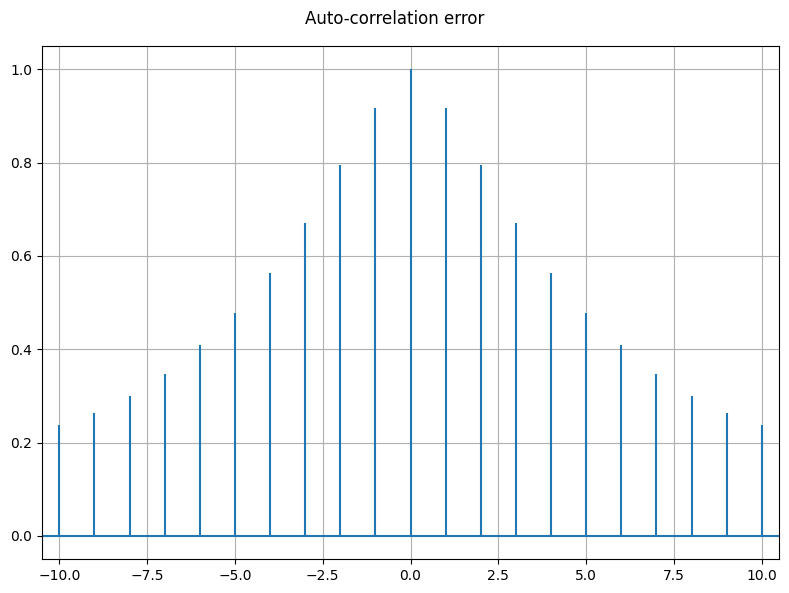

In [ ]:
from __future__ import annotations
import buildingenergy.linreg
import sites.data_h358
import sites.model_h358
import buildingenergy.data

training_data_provider: buildingenergy.data.DataProvider = sites.data_h358.make_h358_data_provider('12/10/2015', ending_stringdate = '31/12/2015')

validation_data_provider: buildingenergy.data.DataProvider = sites.data_h358.make_h358_data_provider()

######## tuning parameter zone #######
offset: bool = True
minimum_input_delay: int = 0
input_names: tuple[str] = ('weather_temperature', 'window_opening', 'Tcorridor', 'door_opening', 'total_electric_power', 'Psun_window', 'dT_heat', 'occupancy')
inputs_maximum_delays: tuple[int] = 10  # (2, 0, 0, 0, 2, 1, 1)
output_name: str = 'Toffice_reference'
ouput_maximum_delay: int = 10
######################################

buildingenergy.linreg.sliding_arx_estimation(output_name,input_names, training_data_provider, offset=offset, minimum_input_delay=minimum_input_delay, inputs_maximum_delays=inputs_maximum_delays, ouput_maximum_delay=ouput_maximum_delay)

training_data_provider.plot()

# Part Calibrating knowledge model [1h]

# 4.1 Introduction

Knowledge model, time-varying (due to variable airflows due to window and door opening) state space model for us, are difficult to tune because
- they are highly nonlinear wrt parameters, that suggest optimization issues for model fitting
- they are identifiability issues, i.e. there are many equivalent solutions for modeling

- considering the second point, exemplify it with a 20cm-concrete, 4cm-foam and 13mm plaster wall. Considering only the static behaviour with thicknesses as parameters, show that there is an infinite set of equivalent parameter values, but only one solution might corresponds to the reality.

__your results 4.1>__

# 4.2 Selection of parameters to be adjusted

- Check and, if necessary, modify the most likely parameter values and extreme bounds for possible parameter values. Intervals on parameter values are going to be used by an exploratory optimization algorithm to search among the possible parameter values, those which minimize the error (absolute value) between simulated office temperature and the CO2 concentration, and the measurement data.

For now, just update the parameter intervals according to your calculations and estimations.

- Check and modified, if you think it's necessary, the following parameters.

__Your results 4.2>__

In [1]:
import buildingenergy.parameters

class H358ParameterSet(buildingenergy.parameters.ParameterSet):
    
    def __init__(self) -> None:
        super().__init__()
        self('body_metabolism', 100, (50, 150, 10))
        self('heater_power_per_delta_surface_temperature', 50, (10, 100, 5))
        self('Qoutdoor0', 0/3600, (0/3600, 20/3600, 10/3600))
        self('Qoutdoor_window', 50/3600, (2/3600, 2000/3600, 10/3600))
        self('Qoutdoor_door', 50/3600, (2/3600, 2000/3600, 10/3600))
        self('Qcorridor0', 0/3600, (0/3600, 20/3600, 10/3600))
        self('Qcorridor_window', 50/3600, (2/3600, 2000/3600, 10/3600))
        self('Qcorridor_door', 50/3600, (2/3600, 2000/3600, 10/3600))
        self('slab_surface_correction', 1, (.1, 3, .1))
        self('room_volume', 52, (45, 70, 1))
        self('psi_bridge', 0.5 * 0.99, (0.0 * 0.99, 0.5 * 5, 0.1))
        self('foam_thickness', 34e-3, (10e-3, 50e-3, 10e-3))
        self('CO2_occupant_breath_production', 13, (7, 25, 1))
        self('solar_factor', 0.4, (.1, .85, .1))
        self('Tdownstairs', 20)
        self('outdoorCCO2', 400, (250, 650, 50))
        
parameter_set: H358ParameterSet = H358ParameterSet()

- to reduce as much as possible the search space for best parameters, an common way is to perform a sensitivity analysis and select the most impacting parameters. We are going to use a Morris sensitivity analysis (see related slides).

- Determine what variables that should be removed from the adjustable parameters. Explain the concept of "trajectory", "levels" (it must an even number), $\mu^*$ and $\sigma$

__your results 4.3>__

In [3]:
import sites.model_h358 
import sites.data_h358
import buildingenergy.fitter
import buildingenergy.data
import time

training_data_period = ('1/03/2015', '1/05/2015')
validation_data_period = ('15/02/2015', '15/02/2016')

parameter_set.reset()

print('Loading training data')
training_data_provider = buildingenergy.data.DataProvider(parameter_set, sites.data_h358.H358Data(training_data_period[0], training_data_period[1], number_of_levels=3),sites.data_h358.h358_model_data_bindings)
sites.data_h358.H358ParameterizedDataSet(training_data_provider)

print('Model generation for training data')
order = None
start: float = time.time()
model_maker = sites.model_h358.H358BuildingModelMaker(training_data_provider, order, sample_time_in_seconds=3600)  # , parameters_levels=None
print('model generation duration: %f secondes' % (time.time() - start))

fitter = buildingenergy.fitter.ModelFitter(model_maker, verbose=False)

print('- Model fitting')
start = time.time()
fitter.sensitivity(2)
print('%i secs' % (time.time() - start))

print('- Nominal simulation on training data (no adjustment)')
print(parameter_set)
simulation_results = fitter.run()
for simulated_variable in simulation_results:
    training_data_provider.add_external_variable(simulated_variable + '_nominal', simulation_results[simulated_variable])
training_data_provider.plot()

Loading training data
variables read from file measurement file:
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, zetaW7, zetaW9, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, humidity, Tyanis, occupancy, detected_motions, illuminance_old, illuminance_new, dT_heat, power_heater, heating_level, total_electric_power, actual_occupation, acoustic_pressure_dB, 
Variable zetaW7 has been removed
Variable zetaW9 has been removed
Variable humidity has been removed
Variable Tyanis has been removed
Variable occupancy has been removed
Variable power_heater has been removed
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_st

13 secs
- Nominal simulation on training data (no adjustment)
+--------------------------------------------+--------+-------------------+-------+-----------+
|                    name                    | value  |     v. bounds     | level | l. bounds |
+--------------------------------------------+--------+-------------------+-------+-----------+
|              body_metabolism               |  100   |     (50, 150)     |   5   |  (0, 10)  |
| heater_power_per_delta_surface_temperature |   50   |     (10, 100)     |   8   |  (0, 18)  |
|                 Qoutdoor0                  |   0    |    (0, 0.00556)   |   0   |   (0, 2)  |
|              Qoutdoor_window               | 0.0117 | (0.000556, 0.556) |   4   |  (0, 199) |
|               Qoutdoor_door                | 0.0117 | (0.000556, 0.556) |   4   |  (0, 199) |
|                 Qcorridor0                 |   0    |    (0, 0.00556)   |   0   |   (0, 2)  |
|              Qcorridor_window              | 0.0117 | (0.000556, 0.556) 

SelectMultiple(description='Select variable to plot', options=('Toffice_wall', 'Tcorridor', 'Theater', 'Toffic…

Button(description='Plot', style=ButtonStyle())

Output()

## 5. Greedy optimization to stay close of the calculated solution

Before running the optimization algorithm for thermal model and CO2 concentration, note that for validating a better parameter set: (a) the simulation errors must be small and not increase during the validation period because it would reveal an over-fitting issue (the model is too complex and start explaining the random noise) (b) the office temperature or the CO2 concentration should be sensitive to each adjustable parameter (we have used a Morris sensitive analysis), otherwise it will overload the optimization process with useless degrees of freedom (c) the parameter values should not reach the bounds of possible values: either the optimization process failed or the model structure is not relevant. Taking into account that the time period for learning is limited to the 2 first months, for each process, analyse the results. The better parameter values are automatically saved to "best_parameters.p" and can be loaded later. If the optimization process is too slow, reduce the popsize (number of indivuals in the population) and the maxiter values (maximum number of iterations) to 20 for instance. Compare the better parameter values with the results before parameter estimation. What about the resulting simulation error on office temperatures and CO2 concentrations?

- Run the parameter adjustement process and analyse the results.

__your results 5.0>__

In [8]:
print('Loading validation data')
validation_data_provider = buildingenergy.data.DataProvider(parameter_set, sites.data_h358.H358Data(validation_data_period[0], validation_data_period[1], number_of_levels=3), sites.data_h358.h358_model_data_bindings)
sites.data_h358.H358ParameterizedDataSet(validation_data_provider)

print('Model generation')
order = None
start: float = time.time()
model_maker = sites.model_h358.H358BuildingModelMaker(training_data_provider, order, sample_time_in_seconds=3600)  # , parameters_levels=None
print('model generation duration: %f secondes' % (time.time() - start))

fitter = buildingenergy.fitter.ModelFitter(model_maker)
print('- Model fitting')
start: float = time.time()
best_parameters, best_validation_outputs, best_validation_error, best_learning_outputs, best_learning_error = fitter.fit(100, validation_data_provider=validation_data_provider)
print(best_parameters)
print('levels=(', ', '.join(['%i' % level for level in validation_data_provider.parameters.adjustable_parameter_levels]), ')')
for simulated_output_name in best_validation_outputs:
    validation_data_provider.add_external_variable(simulated_output_name+'_simulation', best_validation_outputs[simulated_output_name])
validation_data_provider.plot()
print('%i secs' % (time.time() - start))

Loading validation data
variables read from file measurement file:
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, zetaW7, zetaW9, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_stagiaire, humidity, Tyanis, occupancy, detected_motions, illuminance_old, illuminance_new, dT_heat, power_heater, heating_level, total_electric_power, actual_occupation, acoustic_pressure_dB, 
Variable zetaW7 has been removed
Variable zetaW9 has been removed
Variable humidity has been removed
Variable Tyanis has been removed
Variable occupancy has been removed
Variable power_heater has been removed
stringtime, epochtime, datetime, Toffice_wall, Tcorridor, Theater, Toffice_reference, office_CO2_concentration, corridor_CO2_concentration, window_opening, door_opening, power_block_east, power_block_west, power_stephane, power_khadija, power_audrey, power_

TypeError: ModelFitter.run() takes 1 positional argument but 2 were given

## 6. Summary [15min]
Detail and justify the reasons for the different steps to follow for a parameter estimation process (including the way to select a structure).

_your results>_

## 10. Comparison and discussion [30min]
 
Compare the different model fitting approach and determine their advantages and disadvantages (including knowledge and observation models).

_your results>_